<a href="https://colab.research.google.com/github/tabaraei/depression-detection/blob/master/depression_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [5]:
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.notebook import tqdm, trange
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class EATDCorpusDataset(Dataset):
    def __init__(self):
        self.DATA_DIR = '/content/drive/MyDrive/Data/DepressionDetection/EATD-Corpus'
        self.X_train = list()
        self.y_train = list()
        self.X_test = list()
        self.y_test = list()
        self.train = bool()
        self.n_samples_train = 0
        self.n_samples_test = 0
        self.MAX_LENGTH = -1
        self.load_dataset()

    def __getitem__(self, index):
        if self.train:
            return self.X_train[index], self.y_train[index]
        else:
            return self.X_test[index], self.y_test[index]

    def __len__(self):
        if self.train:
            return self.n_samples_train
        else:
            return self.n_samples_test

    def extract_features(self, path):
        sample_rate = librosa.get_samplerate(path)
        waveform, _ = librosa.load(path, mono=True, sr=sample_rate)
        if len(waveform) > 0:
            melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=80)
            log_melspec = librosa.power_to_db(melspec)
            log_melspec = torch.tensor(log_melspec).unsqueeze(dim=0)
            return log_melspec
        else:
            return None

    def load_wav(self, sample):
        # Load the audio files and extract the MelSpec features
        melspec1 = self.extract_features(f'{self.DATA_DIR}/{sample}/positive_out.wav')
        melspec2 = self.extract_features(f'{self.DATA_DIR}/{sample}/neutral_out.wav')
        melspec3 = self.extract_features(f'{self.DATA_DIR}/{sample}/negative_out.wav')
        features = torch.cat([t for t in [melspec1, melspec2, melspec3] if t is not None], dim=-1)

        # Load the labels
        with open(f'{self.DATA_DIR}/{sample}/new_label.txt') as label:
            target = float(label.readline())
            target = [1.0] if target >= 53 else [0.0]

        # compute the max-length audio
        if features.shape[-1] > self.MAX_LENGTH:
            self.MAX_LENGTH = features.shape[-1]

        return features, target

    def add_padding(self, X):
        padded_tensors = list()
        for x in X:
            pad_size = self.MAX_LENGTH - x.shape[-1]
            padded_tensors.append(F.pad(x, (0, pad_size)))
        return torch.stack(padded_tensors)

    def load_dataset(self):
        for sample in tqdm(os.listdir(self.DATA_DIR)):
            features, target = self.load_wav(sample)
            if sample.startswith('t'):
                # Training data
                self.X_train.append(features)
                self.y_train.append(target)
                self.n_samples_train += 1
            else:
                # Test data (duplicate to have two channels)
                self.X_test.append(features)
                self.y_test.append(target)
                self.n_samples_test += 1

        # Add padding and convert to tensors
        self.X_train = self.add_padding(self.X_train)
        self.X_test = self.add_padding(self.X_test)
        self.y_train = torch.tensor(self.y_train)
        self.y_test = torch.tensor(self.y_test)

In [ ]:
DATASET_DIR = '/content/drive/MyDrive/Data/DepressionDetection/EATD-Corpus-Preprocessed'
try:
    with open(f'{DATASET_DIR}/dataset.pkl', 'rb') as f:
        dataset = pickle.load(f)
except:
    dataset = EATDCorpusDataset()
    with open(f'{DATASET_DIR}/dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)

dataset.train = True
print(f'Train Set Dimensions: X={dataset.X_train.shape}, y={dataset.y_train.shape}')
print(f'Train Set Dimensions: X={dataset.X_test.shape}, y={dataset.y_test.shape}')

Train Set Dimensions: X=torch.Size([83, 1, 80, 9278]), y=torch.Size([83, 1])
Train Set Dimensions: X=torch.Size([79, 1, 80, 9278]), y=torch.Size([79, 1])


# Data Preview

In [ ]:
AUDIO_FILE = f'{dataset.DATA_DIR}/t_1/positive_out.wav'
Audio(AUDIO_FILE)

## Torchaudio

In [ ]:
metadata = torchaudio.info(AUDIO_FILE)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=296576, num_channels=2, bits_per_sample=16, encoding=PCM_S)


Waveform size loaded from "torchaudio": torch.Size([1, 296576])
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0036, -0.0035, -0.0083]])


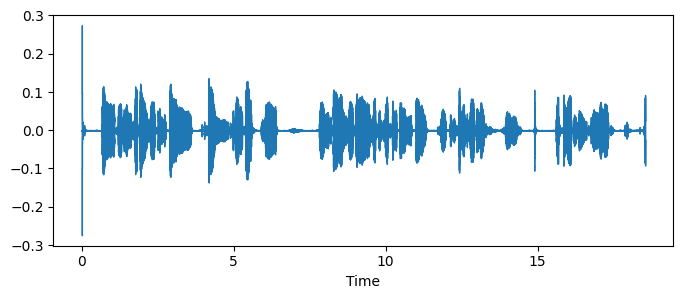

In [ ]:
waveform, sample_rate = torchaudio.load(AUDIO_FILE)
waveform = waveform.mean(dim=0, keepdim=True)
print(f'Waveform size loaded from "torchaudio": {waveform.shape}')
print(waveform)

plt.figure(figsize=(8, 3))
_ = librosa.display.waveshow(waveform.numpy(), sr=sample_rate)

Spectrogram extracted by "torchaudio": torch.Size([1, 80, 1483])


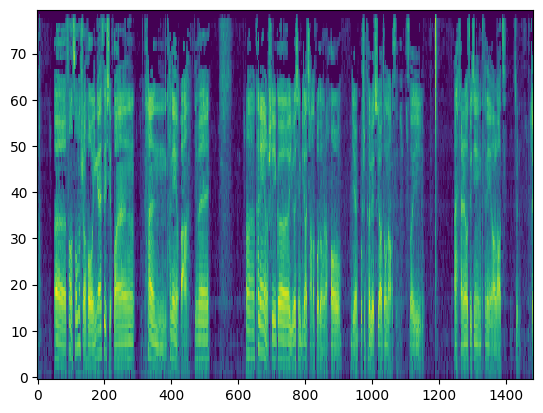

In [ ]:
mel_spectrogram = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=80)
melspec = mel_spectrogram(waveform)
print(f'Spectrogram extracted by "torchaudio": {melspec.shape}')

_ = plt.imshow(librosa.power_to_db(melspec[0]), origin="lower", aspect="auto", interpolation="nearest")

## Librosa

Waveform size loaded from "librosa": torch.Size([296576])
tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.0036, -0.0035, -0.0083])


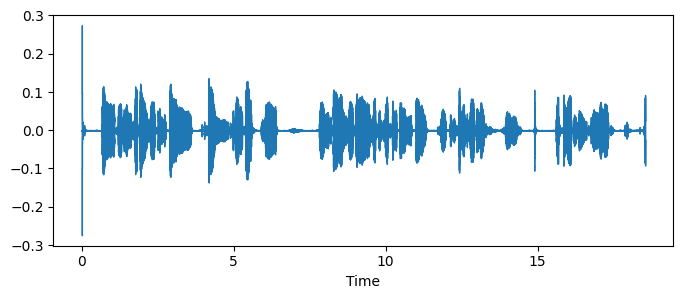

In [ ]:
sample_rate = librosa.get_samplerate(AUDIO_FILE)
waveform, sample_rate = librosa.load(AUDIO_FILE, mono=True, sr=sample_rate)
print(f'Waveform size loaded from "librosa": {torch.tensor(waveform).shape}')
print(torch.tensor(waveform))

plt.figure(figsize=(8, 3))
_ = librosa.display.waveshow(waveform, sr=sample_rate)

Spectrogram extracted by "librosa": (80, 580)


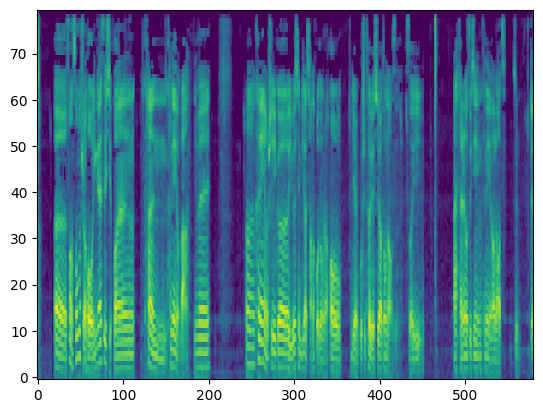

In [ ]:
melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=80)
print(f'Spectrogram extracted by "librosa": {melspec.shape}')

_ = plt.imshow(librosa.power_to_db(melspec), origin="lower", aspect="auto", interpolation="nearest")

## Playground

In [1]:
'''
Step 2: Write a function to compute continuous wavelet transform features of each audio sample
Human Voice Frequency Range:
- The human ear can hear between 20 and 20,000 Hz (20 kHz) but it is most sensitive to everything that happens between 250 and 5,000 Hz.
- The voiced speech of a typical adult male will have a fundamental frequency from 85 to 180 Hz, and that of a typical adult female from 165 to 255 Hz.
- For a child’s voice, average fundamental frequency is 300Hz.
- Consonants take up space between 2kHz and 5kHz.
- Vowel Sounds are prominent between 500Hz and 2kHz.

We will keep frequencies only between 80 Hz and 5KHz.
We will split each audio into frames of length 800.
'''
import numpy as np
import pywt


def compute_wavelet_features(X) :

    # Define a few parameters
    wavelet = 'morl' # wavelet type: morlet
    sr = 8000 # sampling frequency: 8KHz
    widths = np.arange(1, 256) # scales for morlet wavelet
    dt = 1/sr # timestep difference

    frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales

    # Create a filter to select frequencies between 80Hz and 5KHz
    upper = ([x for x in range(len(widths)) if frequencies[x] > 1000])[-1]
    lower = ([x for x in range(len(widths)) if frequencies[x] < 80])[0]
    widths = widths[upper:lower] # Select scales in this frequency range

    # Compute continuous wavelet transform of the audio numpy array
    wavelet_coeffs, freqs = pywt.cwt(X, widths, wavelet = wavelet, sampling_period=dt)
    # print(wavelet_coeffs.shape)
    # sys.exit(1)

    # Split the coefficients into frames of length 800
    start = 0
    end = wavelet_coeffs.shape[1]
    frames = []
    frame_size = 400
    count = 0

    while start+frame_size <= end-1 :

        f = wavelet_coeffs[:,start:start+frame_size]

        # Total samples in a frame will not be a multiple of 800 everytime. If the last frame length is less than 800, we can skip it.
        assert f.shape[1] == frame_size # assert frame lengths are equal to the frame_size parameter

        frames.append(f)
        start += frame_size


    # Convert frames to numpy array
    frames = np.array(frames)
    frames = frames.reshape((len(frames), wavelet_coeffs.shape[0], frame_size))

    return frames

In [13]:
def extract_wavelet_features(path):
    sample_rate = librosa.get_samplerate(path)
    waveform, _ = librosa.load(path, mono=True, sr=sample_rate)
    if len(waveform) > 0:
        sampling_period = 1/sample_rate
        scales = np.arange(1,256)
        frequencies = pywt.scale2frequency(wavelet='morl', scale=scales)/sampling_period
        for x in range(len(scales)):
            print(frequencies[x])
        return None
    else:
        return None

In [14]:
import librosa

DATASET_DIR = '/content/drive/MyDrive/Data/DepressionDetection/EATD-Corpus'
AUDIO_FILE = f'{DATASET_DIR}/t_2/positive_out.wav'

# F = compute_wavelet_features(waveform)
# F = F.astype(np.float16)
extract_wavelet_features(AUDIO_FILE)

13000.0
6500.0
4333.333333333333
3250.0
2600.0
2166.6666666666665
1857.142857142857
1625.0
1444.4444444444443
1300.0
1181.8181818181818
1083.3333333333333
1000.0
928.5714285714286
866.6666666666666
812.5
764.7058823529411
722.2222222222222
684.2105263157895
650.0
619.047619047619
590.9090909090909
565.2173913043478
541.6666666666666
520.0
500.0
481.48148148148147
464.2857142857143
448.2758620689655
433.3333333333333
419.35483870967744
406.25
393.93939393939394
382.35294117647055
371.42857142857144
361.1111111111111
351.35135135135135
342.10526315789474
333.3333333333333
325.0
317.0731707317073
309.5238095238095
302.3255813953488
295.45454545454544
288.88888888888886
282.6086956521739
276.59574468085106
270.8333333333333
265.3061224489796
260.0
254.9019607843137
250.0
245.2830188679245
240.74074074074073
236.36363636363635
232.14285714285714
228.07017543859646
224.13793103448276
220.33898305084745
216.66666666666666
213.11475409836063
209.67741935483872
206.34920634920633
203.125
200.0


In [9]:
F.shape

(741, 76, 400)

In [11]:
F.shape

(163, 76, 400)

# Training

In [ ]:
# Hyper-parameters
num_epochs = 20
learning_rate = 0.001
batch_size = 12

# Preparing the data loader
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# First batch dimensions
X_sample, y_sample = next(iter(data_loader))
X_sample.shape, y_sample.shape

(torch.Size([12, 1, 80, 9278]), torch.Size([12, 1]))

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 8 * 1158, 12)
        self.fc2 = nn.Linear(12, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 8 * 1158)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

# Model, Loss, and Optimizer
model = ConvNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def report_metrics(y_true, y_pred):
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0.0)
    recall = recall_score(y_true, y_pred, zero_division=0.0)
    f1 = f1_score(y_true, y_pred, zero_division=0.0)
    print(f'Accuracy: {accuracy*100:.2f}%, F1-Measure: {f1*100:.2f}%, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%')

    # Confusion Matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)

In [ ]:
# Training
epochs = trange(num_epochs)
for epoch in epochs:
    dataset.train = True
    predictions = list()
    overall_loss = 0.0
    for i, (inputs, labels) in enumerate(data_loader):
        # Computations on GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update loss details on each iteration
        overall_loss += loss.item()
        epochs.set_description(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}')
        predictions.append(outputs.detach().cpu().round())

    # Print some metrics on the training set
    with torch.no_grad():
        print(f'Epoch [{epoch+1}/{num_epochs}], Sum of the BCELoss on training: {overall_loss:.4f}\n')
        print('TRAINING:')
        predictions = torch.cat(predictions)
        report_metrics(dataset.y_train, predictions)
        print()

    # Print some metrics on the validation set
    dataset.train = False
    predictions = list()
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Computations on GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            predictions.append(outputs.cpu().round())

        print('VALIDATION:')
        predictions = torch.cat(predictions)
        report_metrics(dataset.y_test, predictions)
        print('-'*80)

# Saving the model
MODEL_DIR = '/content/drive/MyDrive/Data/DepressionDetection/Model'
torch.save(model, f'{MODEL_DIR}/model.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Sum of the BCELoss on training: 5.3057

TRAINING:
Accuracy: 54.22%, F1-Measure: 36.67%, Precision: 26.83%, Recall: 57.89%
[[34 30]
 [ 8 11]]

VALIDATION:
Accuracy: 75.95%, F1-Measure: 9.52%, Precision: 10.00%, Recall: 9.09%
[[59  9]
 [10  1]]
--------------------------------------------------------------------------------
Epoch [2/20], Sum of the BCELoss on training: 2.8941

TRAINING:
Accuracy: 77.11%, F1-Measure: 38.71%, Precision: 50.00%, Recall: 31.58%
[[58  6]
 [13  6]]

VALIDATION:
Accuracy: 77.22%, F1-Measure: 18.18%, Precision: 18.18%, Recall: 18.18%
[[59  9]
 [ 9  2]]
--------------------------------------------------------------------------------
Epoch [3/20], Sum of the BCELoss on training: 2.5252

TRAINING:
Accuracy: 81.93%, F1-Measure: 44.44%, Precision: 75.00%, Recall: 31.58%
[[62  2]
 [13  6]]

VALIDATION:
Accuracy: 79.75%, F1-Measure: 11.11%, Precision: 14.29%, Recall: 9.09%
[[62  6]
 [10  1]]
----------------------------------------------------------------

# Test

In [ ]:
# Loading the model (if not already in memory)
MODEL_DIR = '/content/drive/MyDrive/Data/DepressionDetection/Model'
model = torch.load(f'{MODEL_DIR}/model.pth').to(device)
model.eval()

ConvNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(2, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=759296, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
dataset.train = False
predictions = list()

with torch.no_grad():
    for inputs, labels in tqdm(data_loader):
        # Computations on GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        predictions.append(outputs.cpu().round())

    predictions = torch.cat(predictions)
    report_metrics(dataset.y_test, predictions)

  0%|          | 0/7 [00:00<?, ?it/s]

Accuracy: 83.54%, F1-Measure: 13.33%, Precision: 25.00%, Recall: 9.09%
[[65  3]
 [10  1]]
